In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset, Dataset,random_split

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

from torch.utils.data import Dataset

import pandas as pd
import shutil

import matplotlib.pyplot as plt

from torchvision import models
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score, recall_score

import os
import cv2
from PIL import Image, ImageEnhance, ImageFilter
from tqdm import tqdm
from torchvision import transforms
import torch
import torch.nn as nn

In [2]:
!curl -L -o Font_recognition.zip https://github.com/NextGen-AI-Camp/curriculum/releases/download/Workshop/Font_recognition.zip
!unzip -o  /content/Font_recognition.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/9ac8a008-12f8-4eb9-a4ef-c2f2d78ccc4e.jpg  
  inflating: images/9adb4195-2a08-4a72-800b-0ceccdd92c56.jpg  
  inflating: images/9ae5ebcc-b744-458c-8ebc-c0bb00ded94a.jpg  
  inflating: images/9ae7c34f-e754-430a-af69-a269c82e0185.jpg  
  inflating: images/9aefd856-6027-4524-bf6b-585aaffc4f64.jpg  
  inflating: images/9af13c53-91e7-4dda-b880-f3d3fa0c3cc2.jpg  
  inflating: images/9afb1f5b-b579-4ea3-b6a8-11afe99c2ac0.jpg  
  inflating: images/9aff54d3-8d05-40e2-9961-0e497fdee70d.jpg  
  inflating: images/9b001318-5721-489f-956d-127dc01c4aba.jpg  
  inflating: images/9b116749-3595-40d6-b592-e78a8d534295.jpg  
  inflating: images/9b12ef52-33f7-431d-83a2-2b7ee3d55e76.jpg  
  inflating: images/9b157027-bb83-40c1-b61b-8bcce87a8c9b.jpg  
  inflating: images/9b1b93f3-4486-4f81-bc9c-22dc7e618e6f.jpg  
  inflating: images/9b1e81ed-04f0-4180-8ef3-051c94f64739.jpg  
  inflating: images/9b1f0e9e-db1c-48dd-835f-c61b1951a4b2.jpg  
  in

In [3]:
def process_csv(csv_path, images_folder, output_base_folder, has_labels=False):
    df = pd.read_csv(csv_path)

    if not os.path.exists(output_base_folder):
        os.makedirs(output_base_folder)

    for index, row in df.iterrows():
        image_path = row['image_path']
        if has_labels:
            font = row.get('font', 'unknown_font')
            font_size = row.get('font_size', 'unknown_size')
            color = row.get('color', 'unknown_color').replace("#", "")

            class_folder = os.path.join(
                output_base_folder,
                color,
                font,
                f"size_{font_size}"
            )
            if not os.path.exists(class_folder):
                os.makedirs(class_folder)
        else:
            class_folder = output_base_folder

        source = os.path.join(images_folder, os.path.basename(image_path))
        destination = os.path.join(class_folder, os.path.basename(image_path))

        if os.path.exists(source):
            shutil.copy2(source, destination)
        else:
            print(f"File {os.path.basename(image_path)} does not exist in {images_folder}")

train_csv_path = '/content/train.csv'
test_csv_path = '/content/test.csv'
images_folder = '/content/images'

train_output_base_folder = '/content/train_pic'
test_output_base_folder = '/content/test_pic'

process_csv(train_csv_path, images_folder, train_output_base_folder, has_labels=True)
process_csv(test_csv_path, images_folder, test_output_base_folder, has_labels=False)

In [9]:
class MultiAlphabetDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        self.color_mapping = {'FF6666': 0, '0000FF': 1, 'A020F0': 2, 'DF3030': 3, '26E953': 4}
        self.font_mapping = {'Athiti-Regular': 0, 'Sarabun-Regular': 1, 'NotoSerifThai-Regular': 2,
                             'Kodchasan-Regular': 3, 'Prompt-Regular': 4, 'KhaosuayThin': 5, 'FkBeautyRegular': 6}
        self.font_size_mapping = {18: 0, 20: 1, 22: 2, 24: 3, 26: 4, 28: 5}

        for color_dir in os.scandir(root_dir):
            if color_dir.is_dir():
                color = color_dir.name
                for font_dir in os.scandir(color_dir.path):
                    if font_dir.is_dir():
                        font = font_dir.name
                        for size_dir in os.scandir(font_dir.path):
                            if size_dir.is_dir() and size_dir.name.startswith("size_"):
                                font_size = int(size_dir.name.split('_')[1])
                                for file in os.scandir(size_dir.path):
                                    if file.is_file():
                                        self.samples.append((file.path, font, font_size, color))

        print(f"Total samples found: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, font, font_size, color = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        font_encoded = torch.tensor(self.font_mapping.get(font), dtype=torch.long)
        font_size_encoded = torch.tensor(self.font_size_mapping.get(font_size), dtype=torch.long)
        color_encoded = torch.tensor(self.color_mapping.get(color), dtype=torch.long)

        return image, color_encoded, font_encoded, font_size_encoded

In [10]:
class ReverseIntensity:
  def __init__(self, threshold=150):
    self.threshold = threshold

  def __call__(self, image):

    if isinstance(image, Image.Image):
      image_np = np.array(image)
    elif isinstance(image, np.ndarray):
      image_np = image
    else:
      raise TypeError("Unsupported type. Expected PIL Image or numpy array.")

    if np.mean(image_np) > self.threshold:
      reversed_image = 255 - image_np
      return Image. fromarray(reversed_image)
    else:
      return image

In [54]:
class Sharpen(object):
    def __call__(self, img):
        enhancer = ImageEnhance.Sharpness(img)
        return enhancer.enhance(5.0)

class BilateralFilter(object):
    def __init__(self, d=9, sigmaColor=87.5, sigmaSpace=87.5):
        self.d = d
        self.sigmaColor = sigmaColor
        self.sigmaSpace = sigmaSpace

    def __call__(self, img):
        img_np = np.array(img)
        filtered_img_np = cv2.bilateralFilter(img_np, self.d, self.sigmaColor, self.sigmaSpace)
        filtered_img = Image.fromarray(filtered_img_np)
        return filtered_img

class ContrastAdjustment:
    def __init__(self, factor=1.5):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(self.factor)
        return img

class TextZoom:
    def __init__(self, scale_factor=0.5):
        self.scale_factor = scale_factor

    def __call__(self, img):
        width, height = img.size
        img = img.resize((int(512 * self.scale_factor), int(62 * self.scale_factor)))
        return img

class RemoveWhiteNoiseAndBackground:
        def __init__(self, threshold=(200, 200, 200)):
            self.threshold = threshold

        def __call__(self, img):

            img_np = np.array(img)

            mask = (img_np[..., 0] >= self.threshold[0]) & \
                (img_np[..., 1] >= self.threshold[1]) & \
                (img_np[..., 2] >= self.threshold[2])

            img_np[mask] = [255, 255, 255]

            return Image.fromarray(img_np)

transform = transforms.Compose([
              RemoveWhiteNoiseAndBackground(),
              BilateralFilter(d=9, sigmaColor=87.5, sigmaSpace=87.5),
              Sharpen(),
              transforms.CenterCrop((40, 460)),
              transforms.ToTensor()
              ])


root_dir = '/content/train_pic'
dataset = MultiAlphabetDataset(root_dir=root_dir, transform=transform)

reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

images, colors, fonts, font_sizes = next(iter(dataloader))

color_names = [reverse_color_mapping[int(color)] for color in colors]
font_names = [reverse_font_mapping[int(font)] for font in fonts]
font_size_names = [reverse_font_size_mapping[int(font_size)] for font_size in font_sizes]

print(f"Batch Images Shape: {images.shape}")
print(f"Batch Colors: {color_names}")
print(f"Batch Fonts: {font_names}")
print(f"Batch Font Sizes: {font_size_names}")

Total samples found: 10080
Batch Images Shape: torch.Size([4, 3, 40, 460])
Batch Colors: ['FF6666', 'FF6666', 'DF3030', 'DF3030']
Batch Fonts: ['NotoSerifThai-Regular', 'Prompt-Regular', 'Sarabun-Regular', 'NotoSerifThai-Regular']
Batch Font Sizes: [26, 28, 28, 20]


In [55]:
def load_data(reverse=False, normalize=False, batch_size=32):
    root_dir = '/content/train_pic'

    train_transform = transforms.Compose([
        RemoveWhiteNoiseAndBackground(),
          BilateralFilter(d=9, sigmaColor=87.5, sigmaSpace=87.5),
          Sharpen(),
          transforms.CenterCrop((40, 460)),
          transforms.ToTensor()
          ])

    dataset = MultiAlphabetDataset(root_dir=root_dir, transform=train_transform)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [56]:
train_loader, test_loader = load_data(reverse=False, normalize=False, batch_size=32)

Total samples found: 10080


In [57]:
def get_dataset_stats(loader):
    font_count = {}
    font_size_count = {}
    color_count = {}
    total_samples = 0

    reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
    reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
    reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

    for batch in loader:
        images, colors, fonts, font_sizes = batch

        color_names = [reverse_color_mapping[int(color)] for color in colors]
        font_names = [reverse_font_mapping[int(font)] for font in fonts]
        font_size_names = [reverse_font_size_mapping[int(font_size)] for font_size in font_sizes]

        for color in color_names:
            if color not in color_count:
                color_count[color] = 0
            color_count[color] += 1

        for font in font_names:
            if font not in font_count:
                font_count[font] = 0
            font_count[font] += 1

        for font_size in font_size_names:
            if font_size not in font_size_count:
                font_size_count[font_size] = 0
            font_size_count[font_size] += 1

        total_samples += len(images)

    return font_count, font_size_count, color_count, total_samples

In [ ]:
train_font_count, train_font_size_count, train_color_count, train_total_samples = get_dataset_stats(train_loader)
test_font_count, test_font_size_count, test_color_count, test_total_samples = get_dataset_stats(test_loader)

print("📃Train Dataset:")
for font, count in train_font_count.items():
    print(f"\tNumber of images with font {font}: {count}")
for font_size, count in train_font_size_count.items():
    print(f"\tNumber of images with font size {font_size}: {count}")
for color, count in train_color_count.items():
    print(f"\tNumber of images with color {color}: {count}")
print(f"\tNumber of training samples: {train_total_samples}")

print("📃Test Dataset:")
for font, count in test_font_count.items():
    print(f"\tNumber of images with font {font}: {count}")
for font_size, count in test_font_size_count.items():
    print(f"\tNumber of images with font size {font_size}: {count}")
for color, count in test_color_count.items():
    print(f"\tNumber of images with color {color}: {count}")
print(f"\tNumber of testing samples: {test_total_samples}")

📃Train Dataset:
	Number of images with font NotoSerifThai-Regular: 1148
	Number of images with font Prompt-Regular: 1128
	Number of images with font Athiti-Regular: 1167
	Number of images with font Kodchasan-Regular: 1180
	Number of images with font FkBeautyRegular: 1152
	Number of images with font KhaosuayThin: 1159
	Number of images with font Sarabun-Regular: 1130
	Number of images with font size 28: 1341
	Number of images with font size 22: 1345
	Number of images with font size 20: 1342
	Number of images with font size 24: 1370
	Number of images with font size 26: 1345
	Number of images with font size 18: 1321
	Number of images with color A020F0: 1614
	Number of images with color 0000FF: 1610
	Number of images with color FF6666: 1609
	Number of images with color DF3030: 1624
	Number of images with color 26E953: 1607
	Number of training samples: 8064
📃Test Dataset:
	Number of images with font Kodchasan-Regular: 260
	Number of images with font Prompt-Regular: 312
	Number of images wit

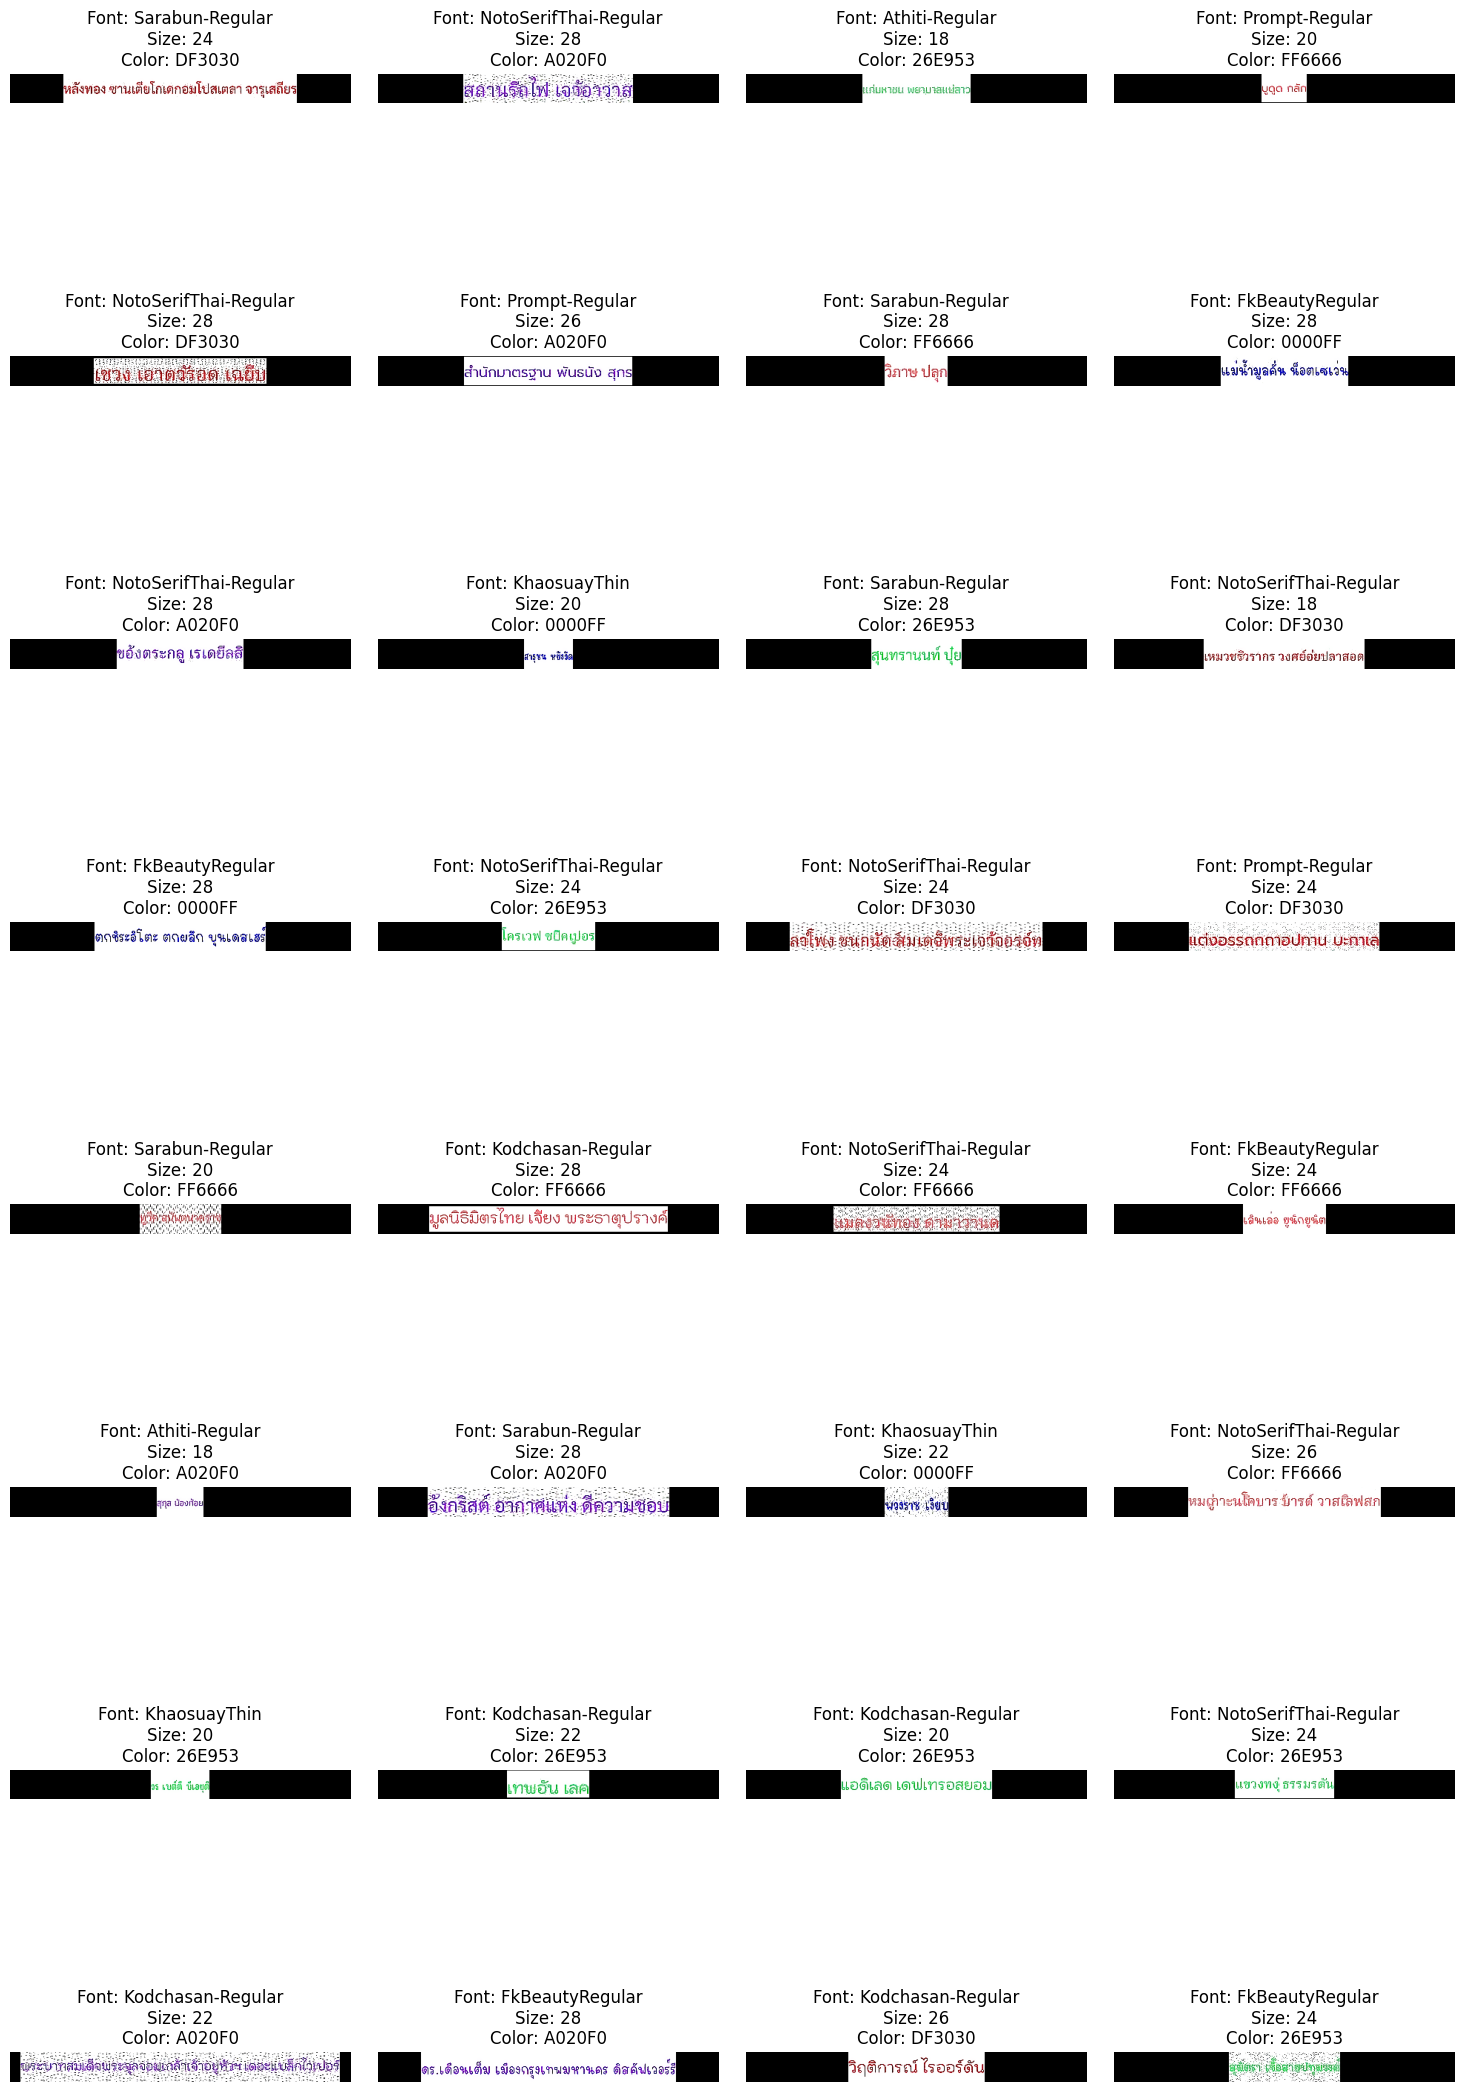

In [59]:
batch_size = 32
images, colors, fonts, font_sizes = next(iter(train_loader))

reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

fig, axes = plt.subplots(8, 4, figsize=(15, 24))
axes = axes.flatten()

for idx, (img, color, font, font_size) in enumerate(zip(images[:batch_size], colors[:batch_size], fonts[:batch_size], font_sizes[:batch_size])):
    ax = axes[idx]

    img_np = img.permute(1, 2, 0).numpy()

    color_name = reverse_color_mapping[int(color)]
    font_name = reverse_font_mapping[int(font)]
    font_size_value = reverse_font_size_mapping[int(font_size)]

    ax.imshow(img_np)
    ax.set_title(f"Font: {font_name}\nSize: {font_size_value}\nColor: {color_name}")
    ax.axis('off')

for ax in axes[len(images[:batch_size]):]:
    ax.axis('off')

plt.tight_layout(pad=2.0)
plt.show()

In [60]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 88.4MB/s]


In [63]:
class CustomVGG16(nn.Module):
    def __init__(self,
                 num_colors=5,
                 num_fonts=7,
                 num_sizes=6,
                 h_dims_color=[128, 128, 128],
                 h_dims_font=[1024, 512, 512],
                 h_dims_size=[1024, 512, 512],
                 input_size=(3, 40, 460)):
        super(CustomVGG16, self).__init__()

        self.vgg16 = models.vgg16(pretrained=True)
        self.vgg16.flatten = nn.Flatten()

        for param in self.vgg16.features.parameters():
            param.requires_grad = True

        for param in self.vgg16.classifier.parameters():
            param.requires_grad = True

        classifier = []
        in_features = self._get_input_size_fc(input_size)

        self.color_classifier = self._create_classifier(in_features, h_dims_color, num_colors)
        self.font_classifier = self._create_classifier(in_features, h_dims_font, num_fonts)
        self.size_classifier = self._create_classifier(in_features, h_dims_size, num_sizes)

    def _get_input_size_fc(self, input_shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            x = self.vgg16.features(dummy_input)
            x = self.vgg16.avgpool(x)
            x = self.vgg16.flatten(x)
            return x.shape[-1]

    def _create_classifier(self, in_features, h_dims, num_classes):
        layers = []
        for hdim in h_dims:
            layers.append(nn.Linear(in_features, hdim))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=0.5))
            in_features = hdim
        layers.append(nn.Linear(in_features, num_classes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.vgg16.features(x)
        x = self.vgg16.avgpool(x)
        x = self.vgg16.flatten(x)

        color_output = self.color_classifier(x)
        font_output = self.font_classifier(x)
        size_output = self.size_classifier(x)

        return color_output, font_output, size_output

In [64]:
num_colors = 5
num_fonts = 7
num_sizes = 6
model = CustomVGG16(num_colors, num_fonts, num_sizes, h_dims_color=[128, 128, 128], h_dims_font=[1024, 512, 512],h_dims_size=[1024, 512, 512])

In [65]:
best_score = 0.0

def calculate_fbeta_score(precision, recall, beta):
    beta_squared = beta ** 2
    return (1 + beta_squared) * (precision * recall) / ((beta_squared * precision) + recall + 1e-7)

def train(model,
          optimizer,
          train_loader,
          test_loader,
          epochs=10,
          beta=1,
          checkpoint_path=None,
          device='cpu',
          patience=3):
    global best_score
    model = model.to(device)
    print("🤖 Training on", device)

    best_loss = float('inf')
    #epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        cross_entropy_loss = nn.CrossEntropyLoss()

        train_bar = tqdm(train_loader,
                         desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]',
                         unit='batch')

        for batch_idx, (data, color_target, font_target, size_target) in enumerate(train_bar):
            data, color_target, font_target, size_target = data.to(device), color_target.to(device), font_target.to(device), size_target.to(device)

            optimizer.zero_grad()

            color_output, font_output, size_output = model(data)
            loss_color = cross_entropy_loss(color_output, color_target)
            loss_font = cross_entropy_loss(font_output, font_target)
            loss_size = cross_entropy_loss(size_output, size_target)

            loss = (loss_color + loss_font + loss_size) / 3

            loss.backward()
            optimizer.step()

            train_bar.set_postfix(loss=loss.item())

        model.eval()
        scheduler.step()

        correct_color, correct_font, correct_size = 0, 0, 0
        test_loss_color, test_loss_font, test_loss_size = 0, 0, 0

        all_color_preds, all_color_targets = [], []
        all_font_preds, all_font_targets = [], []
        all_size_preds, all_size_targets = [], []

        with torch.no_grad():
            test_bar = tqdm(test_loader,
                            desc=f"🧪 Testing Epoch [{epoch+1}/{epochs}]",
                            unit='batch')

            for data, color_target, font_target, size_target in test_bar:
                data, color_target, font_target, size_target = data.to(device), color_target.to(device), font_target.to(device), size_target.to(device)

                color_output, font_output, size_output = model(data)

                test_loss_color += cross_entropy_loss(color_output, color_target).item()
                test_loss_font += cross_entropy_loss(font_output, font_target).item()
                test_loss_size += cross_entropy_loss(size_output, size_target).item()

                color_pred = color_output.argmax(dim=1, keepdim=True)
                font_pred = font_output.argmax(dim=1, keepdim=True)
                size_pred = size_output.argmax(dim=1, keepdim=True)

                correct_color += color_pred.eq(color_target.view_as(color_pred)).sum().item()
                correct_font += font_pred.eq(font_target.view_as(font_pred)).sum().item()
                correct_size += size_pred.eq(size_target.view_as(size_pred)).sum().item()

                all_color_preds.extend(color_pred.cpu().numpy())
                all_color_targets.extend(color_target.cpu().numpy())
                all_font_preds.extend(font_pred.cpu().numpy())
                all_font_targets.extend(font_target.cpu().numpy())
                all_size_preds.extend(size_pred.cpu().numpy())
                all_size_targets.extend(size_target.cpu().numpy())

            test_loss_color /= len(test_loader.dataset)
            test_loss_font /= len(test_loader.dataset)
            test_loss_size /= len(test_loader.dataset)

            accuracy_color = 100. * correct_color / len(test_loader.dataset)
            accuracy_font = 100. * correct_font / len(test_loader.dataset)
            accuracy_size = 100. * correct_size / len(test_loader.dataset)

            precision_color = precision_score(all_color_targets, all_color_preds, average='weighted')
            recall_color = recall_score(all_color_targets, all_color_preds, average='weighted')
            precision_font = precision_score(all_font_targets, all_font_preds, average='weighted')
            recall_font = recall_score(all_font_targets, all_font_preds, average='weighted')
            precision_size = precision_score(all_size_targets, all_size_preds, average='weighted')
            recall_size = recall_score(all_size_targets, all_size_preds, average='weighted')

            fbeta_color = calculate_fbeta_score(precision_color, recall_color, beta)
            fbeta_font = calculate_fbeta_score(precision_font, recall_font, beta)
            fbeta_size = calculate_fbeta_score(precision_size, recall_size, beta)

            fbeta_total = (fbeta_font * 0.3) + (fbeta_color * 0.2) + (fbeta_size * 0.5)

            print(f'Test set:')
            print(f'Average Color loss: {test_loss_color:.4f},🌈 Accuracy: {accuracy_color:.2f}%')
            print(f'Average Font loss: {test_loss_font:.4f},🔤 Accuracy: {accuracy_font:.2f}%')
            print(f'Average Size loss: {test_loss_size:.4f},🔢 Accuracy: {accuracy_size:.2f}%')
            print(f'F-beta Score (Color): {fbeta_color:.4f}, F-beta Score (Font): {fbeta_font:.4f}, F-beta Score (Size): {fbeta_size:.4f}')
            print(f'💡 Real Score (Total F-beta): {fbeta_total:.4f}')

            if fbeta_total > best_score:
                best_score = fbeta_total
                #epochs_without_improvement = 0
                if checkpoint_path:
                    torch.save(model.state_dict(), checkpoint_path)
                    print(f'# 🧠 Best model saved with F-beta Score: {fbeta_total:.4f} at epoch {epoch+1} 🧠')
           # else:
           #    epochs_without_improvement += 1
           #     if epochs_without_improvement >= patience:
           #        print(f"🚨 Early stopping at epoch {epoch+1} due to no improvement.")
           #        break

In [66]:
model = CustomVGG16(num_colors, num_fonts, num_sizes, h_dims_color=[128, 128, 128], h_dims_font=[1024, 512, 512],h_dims_size=[1024, 512, 512])
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0000875, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=50)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train(model=model,
      optimizer=optimizer,
      train_loader=train_loader,
      test_loader=test_loader,
      epochs=50,
      beta=2,
      checkpoint_path="/content/best_model.pth",
      device=device,)  #  patience=3 Patience for Early Stopping

print(f"😎 Best Score is {best_score:.4f}")

🤖 Training on cuda


🧪 Testing Epoch [1/50]: 100%|██████████| 63/63 [00:11<00:00,  5.70batch/s]


Test set:
Average Color loss: 0.0220,🌈 Accuracy: 62.30%
Average Font loss: 0.0533,🔤 Accuracy: 27.68%
Average Size loss: 0.0462,🔢 Accuracy: 31.85%
F-beta Score (Color): 0.6249, F-beta Score (Font): 0.2749, F-beta Score (Size): 0.3253
💡 Real Score (Total F-beta): 0.3701
# 🧠 Best model saved with F-beta Score: 0.3701 at epoch 1 🧠


🧪 Testing Epoch [2/50]: 100%|██████████| 63/63 [00:10<00:00,  5.79batch/s]


Test set:
Average Color loss: 0.0179,🌈 Accuracy: 60.76%
Average Font loss: 0.0282,🔤 Accuracy: 58.93%
Average Size loss: 0.0365,🔢 Accuracy: 46.13%
F-beta Score (Color): 0.6094, F-beta Score (Font): 0.5912, F-beta Score (Size): 0.4550
💡 Real Score (Total F-beta): 0.5268
# 🧠 Best model saved with F-beta Score: 0.5268 at epoch 2 🧠


🧪 Testing Epoch [3/50]: 100%|██████████| 63/63 [00:11<00:00,  5.57batch/s]


Test set:
Average Color loss: 0.0171,🌈 Accuracy: 63.49%
Average Font loss: 0.0134,🔤 Accuracy: 83.13%
Average Size loss: 0.0299,🔢 Accuracy: 57.54%
F-beta Score (Color): 0.6470, F-beta Score (Font): 0.8319, F-beta Score (Size): 0.5740
💡 Real Score (Total F-beta): 0.6660
# 🧠 Best model saved with F-beta Score: 0.6660 at epoch 3 🧠


🧪 Testing Epoch [4/50]: 100%|██████████| 63/63 [00:09<00:00,  6.58batch/s]


Test set:
Average Color loss: 0.0145,🌈 Accuracy: 73.12%
Average Font loss: 0.0101,🔤 Accuracy: 87.85%
Average Size loss: 0.0269,🔢 Accuracy: 62.65%
F-beta Score (Color): 0.7388, F-beta Score (Font): 0.8790, F-beta Score (Size): 0.6255
💡 Real Score (Total F-beta): 0.7242
# 🧠 Best model saved with F-beta Score: 0.7242 at epoch 4 🧠


🧪 Testing Epoch [5/50]: 100%|██████████| 63/63 [00:11<00:00,  5.69batch/s]


Test set:
Average Color loss: 0.0112,🌈 Accuracy: 79.86%
Average Font loss: 0.0081,🔤 Accuracy: 90.62%
Average Size loss: 0.0245,🔢 Accuracy: 68.70%
F-beta Score (Color): 0.7787, F-beta Score (Font): 0.9072, F-beta Score (Size): 0.6864
💡 Real Score (Total F-beta): 0.7711
# 🧠 Best model saved with F-beta Score: 0.7711 at epoch 5 🧠


🧪 Testing Epoch [6/50]: 100%|██████████| 63/63 [00:10<00:00,  5.73batch/s]


Test set:
Average Color loss: 0.0086,🌈 Accuracy: 84.13%
Average Font loss: 0.0049,🔤 Accuracy: 94.39%
Average Size loss: 0.0217,🔢 Accuracy: 69.84%
F-beta Score (Color): 0.8421, F-beta Score (Font): 0.9443, F-beta Score (Size): 0.6983
💡 Real Score (Total F-beta): 0.8008
# 🧠 Best model saved with F-beta Score: 0.8008 at epoch 6 🧠


🧪 Testing Epoch [7/50]: 100%|██████████| 63/63 [00:10<00:00,  6.02batch/s]


Test set:
Average Color loss: 0.0088,🌈 Accuracy: 83.28%
Average Font loss: 0.0042,🔤 Accuracy: 95.04%
Average Size loss: 0.0212,🔢 Accuracy: 72.47%
F-beta Score (Color): 0.8330, F-beta Score (Font): 0.9506, F-beta Score (Size): 0.7255
💡 Real Score (Total F-beta): 0.8145
# 🧠 Best model saved with F-beta Score: 0.8145 at epoch 7 🧠


🧪 Testing Epoch [8/50]: 100%|██████████| 63/63 [00:09<00:00,  6.32batch/s]


Test set:
Average Color loss: 0.0081,🌈 Accuracy: 84.33%
Average Font loss: 0.0051,🔤 Accuracy: 95.19%
Average Size loss: 0.0207,🔢 Accuracy: 74.36%
F-beta Score (Color): 0.8472, F-beta Score (Font): 0.9522, F-beta Score (Size): 0.7437
💡 Real Score (Total F-beta): 0.8269
# 🧠 Best model saved with F-beta Score: 0.8269 at epoch 8 🧠


🧪 Testing Epoch [9/50]: 100%|██████████| 63/63 [00:11<00:00,  5.35batch/s]


Test set:
Average Color loss: 0.0081,🌈 Accuracy: 87.85%
Average Font loss: 0.0060,🔤 Accuracy: 94.69%
Average Size loss: 0.0230,🔢 Accuracy: 69.74%
F-beta Score (Color): 0.8819, F-beta Score (Font): 0.9472, F-beta Score (Size): 0.6972
💡 Real Score (Total F-beta): 0.8091


🧪 Testing Epoch [10/50]: 100%|██████████| 63/63 [00:11<00:00,  5.63batch/s]


Test set:
Average Color loss: 0.0080,🌈 Accuracy: 86.31%
Average Font loss: 0.0042,🔤 Accuracy: 95.59%
Average Size loss: 0.0200,🔢 Accuracy: 75.50%
F-beta Score (Color): 0.8686, F-beta Score (Font): 0.9560, F-beta Score (Size): 0.7551
💡 Real Score (Total F-beta): 0.8381
# 🧠 Best model saved with F-beta Score: 0.8381 at epoch 10 🧠


🧪 Testing Epoch [11/50]: 100%|██████████| 63/63 [00:11<00:00,  5.38batch/s]


Test set:
Average Color loss: 0.0091,🌈 Accuracy: 80.65%
Average Font loss: 0.0050,🔤 Accuracy: 94.54%
Average Size loss: 0.0188,🔢 Accuracy: 78.17%
F-beta Score (Color): 0.8231, F-beta Score (Font): 0.9458, F-beta Score (Size): 0.7815
💡 Real Score (Total F-beta): 0.8391
# 🧠 Best model saved with F-beta Score: 0.8391 at epoch 11 🧠


🧪 Testing Epoch [12/50]: 100%|██████████| 63/63 [00:11<00:00,  5.64batch/s]


Test set:
Average Color loss: 0.0068,🌈 Accuracy: 89.29%
Average Font loss: 0.0044,🔤 Accuracy: 96.08%
Average Size loss: 0.0236,🔢 Accuracy: 76.69%
F-beta Score (Color): 0.8959, F-beta Score (Font): 0.9611, F-beta Score (Size): 0.7672
💡 Real Score (Total F-beta): 0.8511
# 🧠 Best model saved with F-beta Score: 0.8511 at epoch 12 🧠


🧪 Testing Epoch [13/50]: 100%|██████████| 63/63 [00:09<00:00,  6.68batch/s]


Test set:
Average Color loss: 0.0029,🌈 Accuracy: 97.57%
Average Font loss: 0.0042,🔤 Accuracy: 95.88%
Average Size loss: 0.0173,🔢 Accuracy: 81.60%
F-beta Score (Color): 0.9760, F-beta Score (Font): 0.9590, F-beta Score (Size): 0.8161
💡 Real Score (Total F-beta): 0.8909
# 🧠 Best model saved with F-beta Score: 0.8909 at epoch 13 🧠


🧪 Testing Epoch [14/50]: 100%|██████████| 63/63 [00:11<00:00,  5.66batch/s]


Test set:
Average Color loss: 0.0003,🌈 Accuracy: 99.75%
Average Font loss: 0.0031,🔤 Accuracy: 96.88%
Average Size loss: 0.0192,🔢 Accuracy: 81.70%
F-beta Score (Color): 0.9975, F-beta Score (Font): 0.9688, F-beta Score (Size): 0.8172
💡 Real Score (Total F-beta): 0.8987
# 🧠 Best model saved with F-beta Score: 0.8987 at epoch 14 🧠


🧪 Testing Epoch [15/50]: 100%|██████████| 63/63 [00:11<00:00,  5.69batch/s]


Test set:
Average Color loss: 0.0003,🌈 Accuracy: 99.85%
Average Font loss: 0.0053,🔤 Accuracy: 96.13%
Average Size loss: 0.0200,🔢 Accuracy: 79.56%
F-beta Score (Color): 0.9985, F-beta Score (Font): 0.9614, F-beta Score (Size): 0.7962
💡 Real Score (Total F-beta): 0.8862


🧪 Testing Epoch [16/50]: 100%|██████████| 63/63 [00:11<00:00,  5.60batch/s]


Test set:
Average Color loss: 0.0006,🌈 Accuracy: 99.36%
Average Font loss: 0.0036,🔤 Accuracy: 96.58%
Average Size loss: 0.0198,🔢 Accuracy: 77.93%
F-beta Score (Color): 0.9936, F-beta Score (Font): 0.9659, F-beta Score (Size): 0.7793
💡 Real Score (Total F-beta): 0.8782


🧪 Testing Epoch [17/50]: 100%|██████████| 63/63 [00:11<00:00,  5.64batch/s]


Test set:
Average Color loss: 0.0014,🌈 Accuracy: 98.41%
Average Font loss: 0.0039,🔤 Accuracy: 96.92%
Average Size loss: 0.0189,🔢 Accuracy: 82.54%
F-beta Score (Color): 0.9842, F-beta Score (Font): 0.9693, F-beta Score (Size): 0.8260
💡 Real Score (Total F-beta): 0.9006
# 🧠 Best model saved with F-beta Score: 0.9006 at epoch 17 🧠


🧪 Testing Epoch [18/50]: 100%|██████████| 63/63 [00:10<00:00,  6.26batch/s]


Test set:
Average Color loss: 0.0004,🌈 Accuracy: 99.50%
Average Font loss: 0.0038,🔤 Accuracy: 96.48%
Average Size loss: 0.0224,🔢 Accuracy: 82.04%
F-beta Score (Color): 0.9950, F-beta Score (Font): 0.9649, F-beta Score (Size): 0.8208
💡 Real Score (Total F-beta): 0.8989


🧪 Testing Epoch [19/50]: 100%|██████████| 63/63 [00:10<00:00,  6.29batch/s]


Test set:
Average Color loss: 0.0002,🌈 Accuracy: 99.80%
Average Font loss: 0.0033,🔤 Accuracy: 97.22%
Average Size loss: 0.0207,🔢 Accuracy: 82.74%
F-beta Score (Color): 0.9980, F-beta Score (Font): 0.9724, F-beta Score (Size): 0.8284
💡 Real Score (Total F-beta): 0.9055
# 🧠 Best model saved with F-beta Score: 0.9055 at epoch 19 🧠


🧪 Testing Epoch [20/50]: 100%|██████████| 63/63 [00:11<00:00,  5.67batch/s]


Test set:
Average Color loss: 0.0004,🌈 Accuracy: 99.70%
Average Font loss: 0.0152,🔤 Accuracy: 93.01%
Average Size loss: 0.0226,🔢 Accuracy: 80.16%
F-beta Score (Color): 0.9970, F-beta Score (Font): 0.9314, F-beta Score (Size): 0.8016
💡 Real Score (Total F-beta): 0.8796


🧪 Testing Epoch [21/50]: 100%|██████████| 63/63 [00:11<00:00,  5.62batch/s]


Test set:
Average Color loss: 0.0023,🌈 Accuracy: 98.21%
Average Font loss: 0.0112,🔤 Accuracy: 91.37%
Average Size loss: 0.0233,🔢 Accuracy: 80.31%
F-beta Score (Color): 0.9824, F-beta Score (Font): 0.9153, F-beta Score (Size): 0.8030
💡 Real Score (Total F-beta): 0.8725


🧪 Testing Epoch [22/50]: 100%|██████████| 63/63 [00:11<00:00,  5.64batch/s]


Test set:
Average Color loss: 0.0001,🌈 Accuracy: 99.90%
Average Font loss: 0.0033,🔤 Accuracy: 97.07%
Average Size loss: 0.0194,🔢 Accuracy: 84.47%
F-beta Score (Color): 0.9990, F-beta Score (Font): 0.9708, F-beta Score (Size): 0.8451
💡 Real Score (Total F-beta): 0.9136
# 🧠 Best model saved with F-beta Score: 0.9136 at epoch 22 🧠


🧪 Testing Epoch [23/50]: 100%|██████████| 63/63 [00:09<00:00,  6.43batch/s]


Test set:
Average Color loss: 0.0000,🌈 Accuracy: 100.00%
Average Font loss: 0.0044,🔤 Accuracy: 96.73%
Average Size loss: 0.0248,🔢 Accuracy: 80.11%
F-beta Score (Color): 1.0000, F-beta Score (Font): 0.9673, F-beta Score (Size): 0.8021
💡 Real Score (Total F-beta): 0.8912


🧪 Testing Epoch [24/50]: 100%|██████████| 63/63 [00:09<00:00,  6.63batch/s]


Test set:
Average Color loss: 0.0012,🌈 Accuracy: 99.21%
Average Font loss: 0.0068,🔤 Accuracy: 95.09%
Average Size loss: 0.0260,🔢 Accuracy: 80.70%
F-beta Score (Color): 0.9921, F-beta Score (Font): 0.9518, F-beta Score (Size): 0.8085
💡 Real Score (Total F-beta): 0.8882


🧪 Testing Epoch [25/50]: 100%|██████████| 63/63 [00:09<00:00,  6.53batch/s]


Test set:
Average Color loss: 0.0003,🌈 Accuracy: 99.70%
Average Font loss: 0.0043,🔤 Accuracy: 96.48%
Average Size loss: 0.0203,🔢 Accuracy: 83.68%
F-beta Score (Color): 0.9970, F-beta Score (Font): 0.9651, F-beta Score (Size): 0.8374
💡 Real Score (Total F-beta): 0.9076


🧪 Testing Epoch [26/50]: 100%|██████████| 63/63 [00:10<00:00,  6.24batch/s]


Test set:
Average Color loss: 0.0007,🌈 Accuracy: 99.50%
Average Font loss: 0.0031,🔤 Accuracy: 97.27%
Average Size loss: 0.0200,🔢 Accuracy: 82.39%
F-beta Score (Color): 0.9951, F-beta Score (Font): 0.9728, F-beta Score (Size): 0.8240
💡 Real Score (Total F-beta): 0.9029


🧪 Testing Epoch [27/50]: 100%|██████████| 63/63 [00:10<00:00,  6.10batch/s]


Test set:
Average Color loss: 0.0001,🌈 Accuracy: 99.85%
Average Font loss: 0.0031,🔤 Accuracy: 97.42%
Average Size loss: 0.0215,🔢 Accuracy: 81.85%
F-beta Score (Color): 0.9985, F-beta Score (Font): 0.9742, F-beta Score (Size): 0.8192
💡 Real Score (Total F-beta): 0.9016


🧪 Testing Epoch [28/50]: 100%|██████████| 63/63 [00:10<00:00,  6.02batch/s]


Test set:
Average Color loss: 0.0006,🌈 Accuracy: 99.45%
Average Font loss: 0.0047,🔤 Accuracy: 96.18%
Average Size loss: 0.0232,🔢 Accuracy: 82.19%
F-beta Score (Color): 0.9946, F-beta Score (Font): 0.9619, F-beta Score (Size): 0.8238
💡 Real Score (Total F-beta): 0.8994


🧪 Testing Epoch [29/50]: 100%|██████████| 63/63 [00:10<00:00,  6.19batch/s]


Test set:
Average Color loss: 0.0003,🌈 Accuracy: 99.60%
Average Font loss: 0.0037,🔤 Accuracy: 96.97%
Average Size loss: 0.0250,🔢 Accuracy: 81.94%
F-beta Score (Color): 0.9960, F-beta Score (Font): 0.9699, F-beta Score (Size): 0.8208
💡 Real Score (Total F-beta): 0.9005


🧪 Testing Epoch [30/50]: 100%|██████████| 63/63 [00:10<00:00,  6.10batch/s]


Test set:
Average Color loss: 0.0002,🌈 Accuracy: 99.75%
Average Font loss: 0.0041,🔤 Accuracy: 96.68%
Average Size loss: 0.0432,🔢 Accuracy: 71.97%
F-beta Score (Color): 0.9975, F-beta Score (Font): 0.9670, F-beta Score (Size): 0.7219
💡 Real Score (Total F-beta): 0.8505


🧪 Testing Epoch [31/50]: 100%|██████████| 63/63 [00:10<00:00,  6.23batch/s]


Test set:
Average Color loss: 0.0007,🌈 Accuracy: 99.40%
Average Font loss: 0.0043,🔤 Accuracy: 96.97%
Average Size loss: 0.0229,🔢 Accuracy: 83.53%
F-beta Score (Color): 0.9941, F-beta Score (Font): 0.9698, F-beta Score (Size): 0.8358
💡 Real Score (Total F-beta): 0.9077


🧪 Testing Epoch [32/50]: 100%|██████████| 63/63 [00:10<00:00,  6.10batch/s]


Test set:
Average Color loss: 0.0001,🌈 Accuracy: 99.80%
Average Font loss: 0.0033,🔤 Accuracy: 97.12%
Average Size loss: 0.0260,🔢 Accuracy: 81.30%
F-beta Score (Color): 0.9980, F-beta Score (Font): 0.9714, F-beta Score (Size): 0.8133
💡 Real Score (Total F-beta): 0.8977


🧪 Testing Epoch [33/50]: 100%|██████████| 63/63 [00:11<00:00,  5.59batch/s]


Test set:
Average Color loss: 0.0001,🌈 Accuracy: 99.90%
Average Font loss: 0.0039,🔤 Accuracy: 97.22%
Average Size loss: 0.0255,🔢 Accuracy: 81.55%
F-beta Score (Color): 0.9990, F-beta Score (Font): 0.9722, F-beta Score (Size): 0.8156
💡 Real Score (Total F-beta): 0.8993


🧪 Testing Epoch [34/50]: 100%|██████████| 63/63 [00:11<00:00,  5.66batch/s]


Test set:
Average Color loss: 0.0000,🌈 Accuracy: 99.95%
Average Font loss: 0.0036,🔤 Accuracy: 97.27%
Average Size loss: 0.0214,🔢 Accuracy: 83.78%
F-beta Score (Color): 0.9995, F-beta Score (Font): 0.9729, F-beta Score (Size): 0.8377
💡 Real Score (Total F-beta): 0.9106


🧪 Testing Epoch [35/50]: 100%|██████████| 63/63 [00:11<00:00,  5.70batch/s]


Test set:
Average Color loss: 0.0004,🌈 Accuracy: 99.65%
Average Font loss: 0.0038,🔤 Accuracy: 97.22%
Average Size loss: 0.0269,🔢 Accuracy: 83.09%
F-beta Score (Color): 0.9965, F-beta Score (Font): 0.9723, F-beta Score (Size): 0.8320
💡 Real Score (Total F-beta): 0.9070


🧪 Testing Epoch [36/50]: 100%|██████████| 63/63 [00:11<00:00,  5.62batch/s]


Test set:
Average Color loss: 0.0008,🌈 Accuracy: 99.01%
Average Font loss: 0.0065,🔤 Accuracy: 95.68%
Average Size loss: 0.0213,🔢 Accuracy: 83.98%
F-beta Score (Color): 0.9901, F-beta Score (Font): 0.9571, F-beta Score (Size): 0.8399
💡 Real Score (Total F-beta): 0.9051


🧪 Testing Epoch [37/50]: 100%|██████████| 63/63 [00:11<00:00,  5.64batch/s]


Test set:
Average Color loss: 0.0000,🌈 Accuracy: 100.00%
Average Font loss: 0.0034,🔤 Accuracy: 97.47%
Average Size loss: 0.0238,🔢 Accuracy: 83.63%
F-beta Score (Color): 1.0000, F-beta Score (Font): 0.9748, F-beta Score (Size): 0.8371
💡 Real Score (Total F-beta): 0.9110


🧪 Testing Epoch [38/50]: 100%|██████████| 63/63 [00:11<00:00,  5.70batch/s]


Test set:
Average Color loss: 0.0086,🌈 Accuracy: 95.88%
Average Font loss: 0.0082,🔤 Accuracy: 93.90%
Average Size loss: 0.0242,🔢 Accuracy: 82.84%
F-beta Score (Color): 0.9601, F-beta Score (Font): 0.9397, F-beta Score (Size): 0.8289
💡 Real Score (Total F-beta): 0.8884


🧪 Testing Epoch [39/50]: 100%|██████████| 63/63 [00:11<00:00,  5.59batch/s]


Test set:
Average Color loss: 0.0016,🌈 Accuracy: 98.71%
Average Font loss: 0.0084,🔤 Accuracy: 93.75%
Average Size loss: 0.0204,🔢 Accuracy: 83.78%
F-beta Score (Color): 0.9872, F-beta Score (Font): 0.9384, F-beta Score (Size): 0.8383
💡 Real Score (Total F-beta): 0.8981


🧪 Testing Epoch [40/50]: 100%|██████████| 63/63 [00:11<00:00,  5.66batch/s]


Test set:
Average Color loss: 0.0018,🌈 Accuracy: 98.56%
Average Font loss: 0.0039,🔤 Accuracy: 96.63%
Average Size loss: 0.0223,🔢 Accuracy: 82.64%
F-beta Score (Color): 0.9858, F-beta Score (Font): 0.9663, F-beta Score (Size): 0.8269
💡 Real Score (Total F-beta): 0.9005


🧪 Testing Epoch [41/50]: 100%|██████████| 63/63 [00:11<00:00,  5.69batch/s]


Test set:
Average Color loss: 0.0001,🌈 Accuracy: 99.90%
Average Font loss: 0.0033,🔤 Accuracy: 97.97%
Average Size loss: 0.0184,🔢 Accuracy: 86.66%
F-beta Score (Color): 0.9990, F-beta Score (Font): 0.9797, F-beta Score (Size): 0.8668
💡 Real Score (Total F-beta): 0.9271
# 🧠 Best model saved with F-beta Score: 0.9271 at epoch 41 🧠


🧪 Testing Epoch [42/50]: 100%|██████████| 63/63 [00:11<00:00,  5.72batch/s]


Test set:
Average Color loss: 0.0005,🌈 Accuracy: 99.55%
Average Font loss: 0.0043,🔤 Accuracy: 97.07%
Average Size loss: 0.0215,🔢 Accuracy: 84.57%
F-beta Score (Color): 0.9955, F-beta Score (Font): 0.9710, F-beta Score (Size): 0.8467
💡 Real Score (Total F-beta): 0.9138


🧪 Testing Epoch [43/50]: 100%|██████████| 63/63 [00:10<00:00,  5.92batch/s]


Test set:
Average Color loss: 0.0027,🌈 Accuracy: 97.27%
Average Font loss: 0.0043,🔤 Accuracy: 97.02%
Average Size loss: 0.0224,🔢 Accuracy: 81.99%
F-beta Score (Color): 0.9731, F-beta Score (Font): 0.9703, F-beta Score (Size): 0.8211
💡 Real Score (Total F-beta): 0.8963


🧪 Testing Epoch [44/50]: 100%|██████████| 63/63 [00:10<00:00,  6.13batch/s]


Test set:
Average Color loss: 0.0015,🌈 Accuracy: 98.56%
Average Font loss: 0.0045,🔤 Accuracy: 96.28%
Average Size loss: 0.0268,🔢 Accuracy: 82.04%
F-beta Score (Color): 0.9858, F-beta Score (Font): 0.9630, F-beta Score (Size): 0.8215
💡 Real Score (Total F-beta): 0.8968


🧪 Testing Epoch [45/50]: 100%|██████████| 63/63 [00:12<00:00,  5.16batch/s]


Test set:
Average Color loss: 0.0001,🌈 Accuracy: 99.85%
Average Font loss: 0.0033,🔤 Accuracy: 97.32%
Average Size loss: 0.0198,🔢 Accuracy: 80.61%
F-beta Score (Color): 0.9985, F-beta Score (Font): 0.9732, F-beta Score (Size): 0.8067
💡 Real Score (Total F-beta): 0.8950


🧪 Testing Epoch [46/50]: 100%|██████████| 63/63 [00:09<00:00,  6.59batch/s]


Test set:
Average Color loss: 0.0001,🌈 Accuracy: 99.90%
Average Font loss: 0.0024,🔤 Accuracy: 98.31%
Average Size loss: 0.0202,🔢 Accuracy: 85.66%
F-beta Score (Color): 0.9990, F-beta Score (Font): 0.9831, F-beta Score (Size): 0.8576
💡 Real Score (Total F-beta): 0.9236


🧪 Testing Epoch [47/50]: 100%|██████████| 63/63 [00:09<00:00,  6.46batch/s]


Test set:
Average Color loss: 0.0000,🌈 Accuracy: 100.00%
Average Font loss: 0.0046,🔤 Accuracy: 96.18%
Average Size loss: 0.0254,🔢 Accuracy: 84.18%
F-beta Score (Color): 1.0000, F-beta Score (Font): 0.9622, F-beta Score (Size): 0.8423
💡 Real Score (Total F-beta): 0.9098


🧪 Testing Epoch [48/50]: 100%|██████████| 63/63 [00:10<00:00,  5.85batch/s]


Test set:
Average Color loss: 0.0002,🌈 Accuracy: 99.75%
Average Font loss: 0.0101,🔤 Accuracy: 92.81%
Average Size loss: 0.0239,🔢 Accuracy: 84.18%
F-beta Score (Color): 0.9975, F-beta Score (Font): 0.9299, F-beta Score (Size): 0.8420
💡 Real Score (Total F-beta): 0.8995


🧪 Testing Epoch [49/50]: 100%|██████████| 63/63 [00:10<00:00,  5.76batch/s]


Test set:
Average Color loss: 0.0011,🌈 Accuracy: 99.16%
Average Font loss: 0.0044,🔤 Accuracy: 97.12%
Average Size loss: 0.0242,🔢 Accuracy: 82.09%
F-beta Score (Color): 0.9916, F-beta Score (Font): 0.9714, F-beta Score (Size): 0.8213
💡 Real Score (Total F-beta): 0.9004


🧪 Testing Epoch [50/50]: 100%|██████████| 63/63 [00:10<00:00,  5.96batch/s]


Test set:
Average Color loss: 0.0026,🌈 Accuracy: 98.31%
Average Font loss: 0.0029,🔤 Accuracy: 97.67%
Average Size loss: 0.0277,🔢 Accuracy: 83.18%
F-beta Score (Color): 0.9833, F-beta Score (Font): 0.9767, F-beta Score (Size): 0.8329
💡 Real Score (Total F-beta): 0.9061
😎 Best Score is 0.9271


In [68]:
model = CustomVGG16(num_colors, num_fonts, num_sizes, h_dims_color=[128, 128, 128], h_dims_font=[1024, 512, 512],h_dims_size=[1024, 512, 512])
model.load_state_dict(torch.load('/content/best_model.pth'))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

file_names, font_preds, size_preds, color_preds = [], [], [], []

submit_transform  = transforms.Compose([
          RemoveWhiteNoiseAndBackground(),
          BilateralFilter(d=9, sigmaColor=87.5, sigmaSpace=87.5),
          Sharpen(),
          transforms.CenterCrop((40, 460)),
          transforms.ToTensor()
          ])

csv_file = '/content/test.csv'
df = pd.read_csv(csv_file)

file_paths_from_csv = df.iloc[:, 0]

reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

with torch.no_grad():
    submit_bar = tqdm(file_paths_from_csv, desc=f'📄 Submitting...', unit='image')
    for img_path in submit_bar:

        if not os.path.exists(img_path):
            print(f"File {img_path} does not exist.")
            continue

        image = Image.open(img_path).convert('RGB')
        image = submit_transform(image)
        image = image.unsqueeze(0).to(device)

        color_output, font_output, size_output = model(image)

        color_pred = color_output.argmax(dim=1, keepdim=True).item()
        color_preds.append(reverse_color_mapping[color_pred])

        font_pred = font_output.argmax(dim=1, keepdim=True).item()
        font_preds.append(reverse_font_mapping[font_pred])

        size_pred = size_output.argmax(dim=1, keepdim=True).item()
        size_preds.append(reverse_font_size_mapping[size_pred])

        file_name = os.path.basename(img_path)
        file_names.append(f"images/{file_name}")

data = list(zip(file_names, font_preds, size_preds, color_preds))
submission_df = pd.DataFrame(data, columns=['image_path', 'font', 'font_size', 'color'])

output_path = '/content/WorkShopSubmission.csv'
submission_df.to_csv(output_path, index=False)

print(f"CSV file saved to {output_path}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
📄 Submitting...: 100%|██████████| 2520/2520 [00:20<00:00, 123.03image/s]

CSV file saved to /content/WorkShopSubmission.csv
